In [1]:
import yfinance as yf
import pandas as pd

tickers = ['RELIANCE.NS', 'TCS.NS', 'HDFCBANK.NS', 'INFY.NS', 'ICICIBANK.NS']
start_date = '2019-01-01'
end_date = '2024-01-01'

data = yf.download(tickers, start=start_date, end=end_date)['Close']
data.head()

/tmp/ipython-input-3143148463.py:8: FutureWarning: YF.download() has changed argument auto_adjust default to True
  data = yf.download(tickers, start=start_date, end=end_date)['Close']
[*********************100%***********************]  5 of 5 completed


Ticker,HDFCBANK.NS,ICICIBANK.NS,INFY.NS,RELIANCE.NS,TCS.NS
Date,,,,,
2019-01-01,490.160889,350.957001,568.239990,498.490570,1717.571655
2019-01-02,485.688477,351.777130,571.657654,491.998260,1736.075928
2019-01-03,481.877808,350.474609,571.743225,485.928314,1714.998657
2019-01-04,483.167053,352.356079,564.822144,488.551910,1694.147583
2019-01-07,483.897217,354.768066,573.921997,491.264526,1713.148315


In [2]:
import numpy as np

returns = data.pct_change().dropna()
expected_returns = returns.mean() * 252
cov_matrix = returns.cov() * 252

print("Annualized Expected Returns:")
print(expected_returns)
print("\nAnnualized Covariance Matrix:")
print(cov_matrix)

Annualized Expected Returns:
Ticker
HDFCBANK.NS     0.142354
ICICIBANK.NS    0.264253
INFY.NS         0.237621
RELIANCE.NS     0.239133
TCS.NS          0.186646
dtype: float64

Annualized Covariance Matrix:
Ticker        HDFCBANK.NS  ICICIBANK.NS   INFY.NS  RELIANCE.NS    TCS.NS
Ticker                                                                  
HDFCBANK.NS      0.072133      0.057035  0.025998     0.035106  0.020510
ICICIBANK.NS     0.057035      0.108210  0.029953     0.041080  0.024038
INFY.NS          0.025998      0.029953  0.082636     0.028199  0.045392
RELIANCE.NS      0.035106      0.041080  0.028199     0.092501  0.026724
TCS.NS           0.020510      0.024038  0.045392     0.026724  0.061401


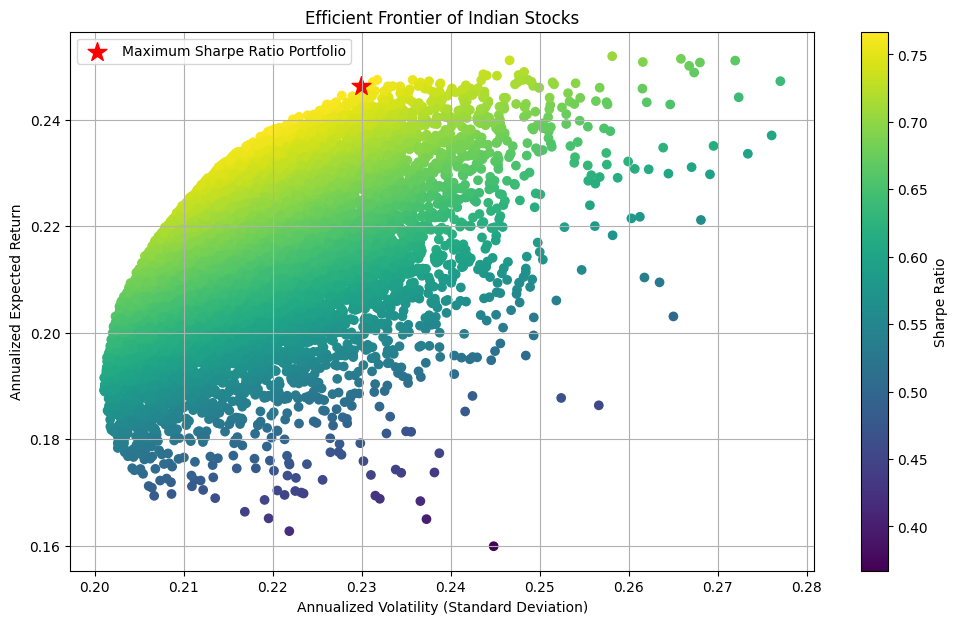

In [3]:
import matplotlib.pyplot as plt

num_portfolios = 20000
results = np.zeros((3, num_portfolios))
risk_free_rate = 0.07

for i in range(num_portfolios):
    weights = np.random.random(len(tickers))
    weights /= np.sum(weights)

    portfolio_return = np.sum(expected_returns * weights)
    portfolio_std_dev = np.sqrt(np.dot(weights.T, np.dot(cov_matrix, weights)))

    results[0,i] = portfolio_return
    results[1,i] = portfolio_std_dev
    results[2,i] = (portfolio_return - risk_free_rate) / portfolio_std_dev

max_sharpe_idx = np.argmax(results[2])
max_sharpe_return = results[0,max_sharpe_idx]
max_sharpe_std_dev = results[1,max_sharpe_idx]

plt.figure(figsize=(12, 7))
plt.scatter(results[1,:], results[0,:], c=results[2,:], cmap='viridis', marker='o')
plt.colorbar(label='Sharpe Ratio')
plt.xlabel('Annualized Volatility (Standard Deviation)')
plt.ylabel('Annualized Expected Return')
plt.title('Efficient Frontier of Indian Stocks')

plt.scatter(max_sharpe_std_dev, max_sharpe_return, marker='*', color='r', s=200, label='Maximum Sharpe Ratio Portfolio')
plt.legend(labelspacing=0.8)
plt.grid(True)
plt.show()

In [4]:
from scipy.optimize import minimize

num_assets = len(tickers)

# Equal Weight Portfolio
ew_weights = np.array([1/num_assets] * num_assets)
ew_return = np.sum(expected_returns * ew_weights)
ew_std_dev = np.sqrt(np.dot(ew_weights.T, np.dot(cov_matrix, ew_weights)))

# Global Minimum Variance Portfolio
def portfolio_variance(weights, cov_matrix):
    return np.dot(weights.T, np.dot(cov_matrix, weights))

constraints = ({'type': 'eq', 'fun': lambda x: np.sum(x) - 1})
bounds = tuple((0, 1) for asset in range(num_assets))
initial_guess = num_assets * [1. / num_assets,]

gmv_result = minimize(portfolio_variance, initial_guess, args=(cov_matrix,), method='SLSQP', bounds=bounds, constraints=constraints)
gmv_weights = gmv_result.x
gmv_return = np.sum(expected_returns * gmv_weights)
gmv_std_dev = np.sqrt(gmv_result.fun)

print("Equal Weight (EW) Portfolio:")
print(f"  Return: {ew_return:.4f}, Volatility: {ew_std_dev:.4f}")
print("  Weights:", dict(zip(tickers, ew_weights)))

print("\nGlobal Minimum Variance (GMV) Portfolio:")
print(f"  Return: {gmv_return:.4f}, Volatility: {gmv_std_dev:.4f}")
print("  Weights:", dict(zip(tickers, np.round(gmv_weights, 4))))

Equal Weight (EW) Portfolio:
  Return: 0.2140, Volatility: 0.2083
  Weights: {'RELIANCE.NS': np.float64(0.2), 'TCS.NS': np.float64(0.2), 'HDFCBANK.NS': np.float64(0.2), 'INFY.NS': np.float64(0.2), 'ICICIBANK.NS': np.float64(0.2)}

Global Minimum Variance (GMV) Portfolio:
  Return: 0.1894, Volatility: 0.2010
  Weights: {'RELIANCE.NS': np.float64(0.3104), 'TCS.NS': np.float64(0.029), 'HDFCBANK.NS': np.float64(0.1148), 'INFY.NS': np.float64(0.1607), 'ICICIBANK.NS': np.float64(0.385)}


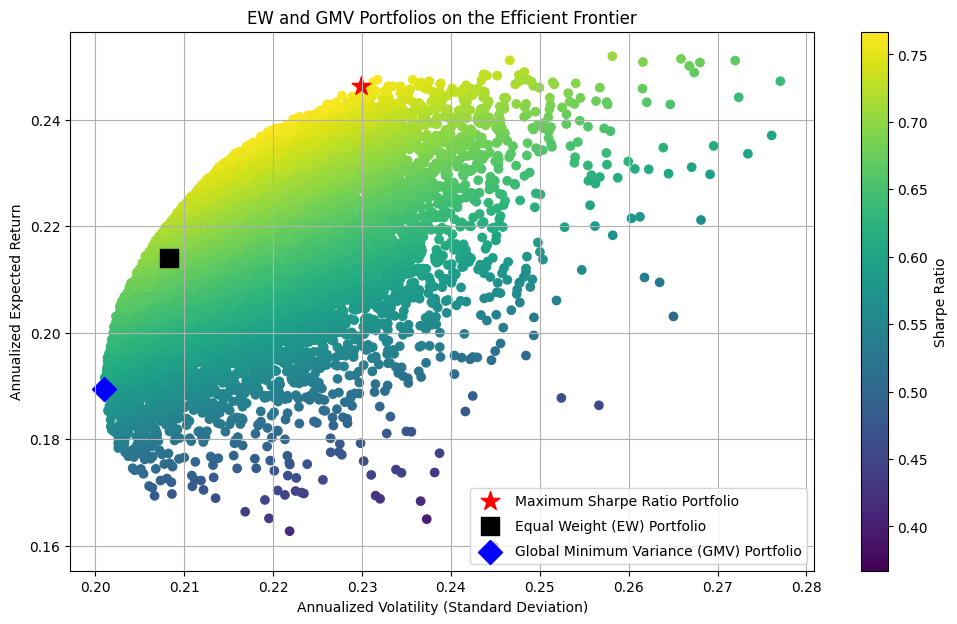

In [5]:
plt.figure(figsize=(12, 7))
plt.scatter(results[1,:], results[0,:], c=results[2,:], cmap='viridis', marker='o')
plt.colorbar(label='Sharpe Ratio')
plt.xlabel('Annualized Volatility (Standard Deviation)')
plt.ylabel('Annualized Expected Return')
plt.title('EW and GMV Portfolios on the Efficient Frontier')

plt.scatter(max_sharpe_std_dev, max_sharpe_return, marker='*', color='r', s=200, label='Maximum Sharpe Ratio Portfolio')
plt.scatter(ew_std_dev, ew_return, marker='s', color='black', s=150, label='Equal Weight (EW) Portfolio')
plt.scatter(gmv_std_dev, gmv_return, marker='D', color='blue', s=150, label='Global Minimum Variance (GMV) Portfolio')

plt.legend(labelspacing=0.8)
plt.grid(True)
plt.show()

Based on the efficient frontier, the Global Minimum Variance (GMV) portfolio is the ideal choice for a highly risk-averse investor, offering the absolute lowest volatility but a consequently modest expected return. In contrast, the Equal Weight (EW) portfolio provides a higher expected return but at the cost of greater risk. Critically, the GMV portfolio is considered efficient as it lies on the optimal frontier, while the EW portfolio is inefficient because it falls inside the curve, indicating that a better risk-return trade-off is achievable.

#CONCLUSION

This analysis successfully constructed and evaluated investment portfolios based on five years of historical returns from prominent Indian stocks, applying the principles of Modern Portfolio Theory. By calculating the annualized expected returns and the covariance matrix for the selected assets, an efficient frontier was plotted to visually represent the set of optimal portfolios. The investigation revealed that the Global Minimum Variance (GMV) portfolio, as expected, is an efficient portfolio located at the tip of the frontier, offering the lowest possible risk for a corresponding return. In contrast, the simplistic Equal Weight (EW) portfolio, while yielding a higher return in this specific historical period, was demonstrated to be inefficient as it resides inside the frontier. This positioning proves that a superior risk-adjusted return could have been achieved through a more strategically optimized allocation. Ultimately, this report underscores the importance of quantitative analysis in portfolio construction, showing that an optimized portfolio like the GMV provides a measurably more efficient risk-return profile than a simple diversification strategy.